[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/envelope-and-fine-structure/blob/master/test_sf_vae.ipynb)

###### 환경 설정

In [ ]:
!git clone https://github.com/shhommychon/envelope-and-fine-structure
!git clone https://github.com/samsad35/source-filter-vae
!cd source-filter-vae/ && pip install -e .
!pip install --upgrade pip setuptools wheel
!apt install portaudio19-dev
!pip -qq install pyaudio pyworld

In [2]:
import sys
sys.path.append("/content/envelope-and-fine-structure")
sys.path.append("/content/source-filter-vae")

In [3]:
with open("/content/source-filter-vae/sf_vae/sf_vae/f0_detection/__init__.py", 'r') as f:
    code = f.readlines()
with open("/content/source-filter-vae/sf_vae/sf_vae/f0_detection/__init__.py", 'w') as f:
    for line in code:
        f.write("# " + line)

with open("/content/source-filter-vae/sf_vae/sf_vae/__init__.py", 'r') as f:
    code = f.readlines()
code[4] = "# " + code[4]
with open("/content/source-filter-vae/sf_vae/sf_vae/__init__.py", 'w') as f:
    for line in code:
        f.write(line)

with open("/content/source-filter-vae/sf_vae/__init__.py", 'r') as f:
    code = f.readlines()
code[2] = code[2].replace("Controlling,", "Controlling#,")
with open("/content/source-filter-vae/sf_vae/__init__.py", 'w') as f:
    for line in code:
        f.write(line)

with open("/content/source-filter-vae/sf_vae/sf_vae/method/controling.py", 'r') as f:
    code = f.read()
code = code.replace(r'''
    def load_models(self, factor, load_regression: bool = True):
        """
            Load PCA + Regression parameters.
        :param load_regression:
        :param factor: f0 -> (source), f1, f2, f3 -> (filter).
        :return: void.
        """
        with open(f"{self.path}\\pca_{factor}", 'rb') as f:
            pca = pickle.load(f)
            self.U, self.mean, self.eigenvalues, self.__ratio = pca['u'], pca['mean'], pca['eigenvalues'], pca['ratio']
        if load_regression:
            self.pwl = []
            for i in range(len(self.eigenvalues)):
                with open(f"{self.path}\\pwl_{factor}_axe{i}", 'rb') as f:
                    self.pwl.append(pickle.load(f))
        print(f"Models pca + Regression loaded successfully [{factor}, ratio: {np.sum(self.__ratio) * 100}] ")
''', r'''
    def load_models(self, factor, load_regression: bool = True):
        """
            Load PCA + Regression parameters.
        :param load_regression:
        :param factor: f0 -> (source), f1, f2, f3 -> (filter).
        :return: void.
        """
        with open(f"{self.path}/pca_{factor}", 'rb') as f:
            pca = pickle.load(f)
            self.U, self.mean, self.eigenvalues, self.__ratio = pca['u'], pca['mean'], pca['eigenvalues'], pca['ratio']
        if load_regression:
            self.pwl = []
            for i in range(len(self.eigenvalues)):
                with open(f"{self.path}/pwl_{factor}_axe{i}", 'rb') as f:
                    self.pwl.append(pickle.load(f))
        print(f"Models pca + Regression loaded successfully [{factor}, ratio: {np.sum(self.__ratio) * 100}] ")
''')
code = code.replace(r'''
    def reconstruction(self, z, save: bool = False, path_new_wav: str = "out.wav",
                       method_reconstruction="RTISI"):
        """
            Get the audio signal from latent space vae Z
        :param method_reconstruction:
        :param z: latent space.
        :param save: True if you would to save the output signal audio.
        :param path_new_wav: the path/name of the new output signal audio if save == True.
        :return: the output signal audio
        """
        spec = self.model.decode(torch.from_numpy(z).type(torch.FloatTensor).to(self.device))
        spec = torch.sqrt(spec)
        spec = torch.transpose(spec, 0, 1).detach().cpu().numpy()
        window = get_window(window=self.tools.stft_waveglow.window,
                            Nx=self.tools.stft_waveglow.win_length, fftbins=True)
        window = pad_center(window, self.tools.stft_waveglow.filter_length)
        window = torch.from_numpy(window).float()
        if method_reconstruction.upper() == "RTISI":
            signal_recons = RTISI_LA(torch.from_numpy(spec),
                                     hop_length=self.tools.stft_waveglow.hop_length,
                                     win_length=self.tools.stft_waveglow.win_length,
                                     window=window).numpy()
        elif method_reconstruction.upper() == "GRIFFIN":
            signal_recons = griffin_lim(torch.from_numpy(spec), maxiter=100, alpha=0.3, window=window,
                                        hop_length=self.tools.stft_waveglow.hop_length,
                                        win_length=self.tools.stft_waveglow.win_length).numpy()
        elif method_reconstruction.upper() == "WAVEGLOW":
            # --- WaveGlow ---
            mel_recon = self.tools.spec2mel(spec)  # numpy array
            melspectrogram_reconstructed = self.tools.dynamic_range_compression(mel_recon)
            signal_recons = self.tools.audio_reconstruction_waveGlow(melspectrogram_reconstructed.cuda())
        else:
            raise Exception('choose: RTISI or GRIFFIN or WAVEGLOW as method of reconstruction')

        if save:
            write(path_new_wav, 16000, signal_recons)
        return signal_recons, spec
''', r'''
    def reconstruction(self, z, save: bool = False, path_new_wav: str = "out.wav",
                       method_reconstruction="RTISI"):
        """
            Get the audio signal from latent space vae Z
        :param method_reconstruction:
        :param z: latent space.
        :param save: True if you would to save the output signal audio.
        :param path_new_wav: the path/name of the new output signal audio if save == True.
        :return: the output signal audio
        """
        spec = self.model.decode(torch.from_numpy(z).type(torch.FloatTensor).to(self.device))
        spec = torch.sqrt(spec)
        spec = torch.transpose(spec, 0, 1).detach().cpu().numpy()
        window = get_window(window=self.tools.stft_waveglow.window,
                            Nx=self.tools.stft_waveglow.win_length, fftbins=True)
        window = pad_center(window, self.tools.stft_waveglow.filter_length)
        window = torch.from_numpy(window).float()
        # if method_reconstruction.upper() == "RTISI":
        #     signal_recons = RTISI_LA(torch.from_numpy(spec),
        #                              hop_length=self.tools.stft_waveglow.hop_length,
        #                              win_length=self.tools.stft_waveglow.win_length,
        #                              window=window).numpy()
        # elif method_reconstruction.upper() == "GRIFFIN":
        #     signal_recons = griffin_lim(torch.from_numpy(spec), maxiter=100, alpha=0.3, window=window,
        #                                 hop_length=self.tools.stft_waveglow.hop_length,
        #                                 win_length=self.tools.stft_waveglow.win_length).numpy()
        # elif method_reconstruction.upper() == "WAVEGLOW":
            # --- WaveGlow ---
        mel_recon = self.tools.spec2mel(spec)  # numpy array
        melspectrogram_reconstructed = self.tools.dynamic_range_compression(mel_recon)
            # signal_recons = self.tools.audio_reconstruction_waveGlow(melspectrogram_reconstructed.cuda())
        # else:
            # raise Exception('choose: RTISI or GRIFFIN or WAVEGLOW as method of reconstruction')

        # if save:
            # write(path_new_wav, 16000, signal_recons)
        return melspectrogram_reconstructed # signal_recons, spec
''')
code = code.replace(r'''
    def whispering(self, path_wav: str = None):
        """
            Whispering
        :param path_wav: the path to .wav file.
        :return: The new Z.
        """
        self.load_models('f0')
        z, _ = self.get_z(path_wav)
        z_ = z - self.ipca(self.pca(z))
        return z_
''', r'''
    def whispering(self, path_wav: str = None):
        """
            Whispering
        :param path_wav: the path to .wav file.
        :return: The new Z.
        """
        self.load_models('f0')
        z, _ = self.get_z(path_wav)
        z0 = self.ipca(self.pca(z))
        z_ = z - z0
        return z_, z0
''')
with open("/content/source-filter-vae/sf_vae/sf_vae/method/controling.py", 'w') as f:
    for line in code:
        f.write(line)

###### 코드

In [4]:
from envelope import DirectPeakDetection

algo1 = DirectPeakDetection(freq_cut=600, interval_length=100)

In [5]:
from envelope.base import BaseEnvelopeAlgo

class SourceFilterVAE(BaseEnvelopeAlgo):
    """Source-Filter-VAE

    model trained and implemented by Samir Sadok
        - https://github.com/samsad35/source-filter-vae
    """
    def __init__(
        self,
        vae_checkpoint_path="source-filter-vae/checkpoints/vae_trained",
        controlling_path=r"source-filter-vae/checkpoints/pca-regression",
        controlling_device="cpu"
    ):
        import torch
        from sf_vae import Controlling
        from sf_vae import VAE

        vae = VAE()
        vae.load_state_dict(torch.load(vae_checkpoint_path)['model_state_dict'])
        self.control = Controlling(
            path=controlling_path,
            model=vae,
            device=controlling_device
        )

    def __call__(self, wav_path="envelope-and-fine-structure/_sample/chonsh_hello.wav", **kwargs):
        z_, z0 = self.control.whispering(path_wav=wav_path)
        
        mel_envelopes = self.control.reconstruction(z_)
        mel_fine_structures = self.control.reconstruction(z0)

        return mel_envelopes.detach().cpu().numpy(), mel_fine_structures.detach().cpu().numpy()

In [6]:
algo2 = SourceFilterVAE()

Downloading: "https://github.com/nvidia/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


In [7]:
sr, data = algo1.read_wav("/content/envelope-and-fine-structure/_sample/chonsh_hello.wav")

data = data / 32768
e1, f1 = algo1(data, sampling_rate=sr)

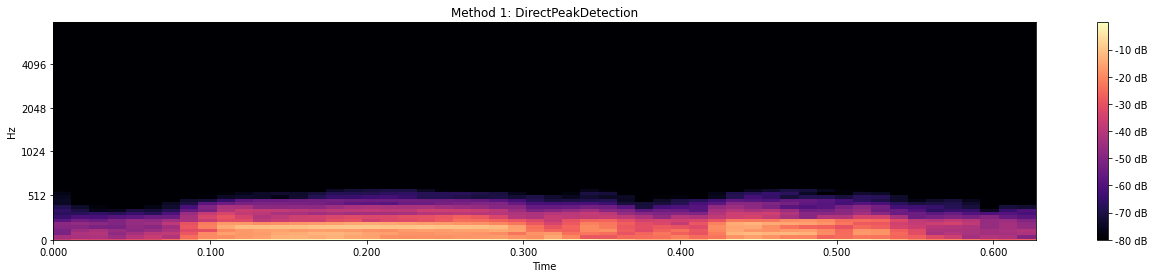

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(22,4))
img = librosa.display.specshow(
    librosa.power_to_db(
        librosa.feature.melspectrogram(y=e1, sr=sr, n_mels=80, fmax=8000), 
        ref=np.max
    ), 
    x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax
)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Method 1: DirectPeakDetection')
plt.show()

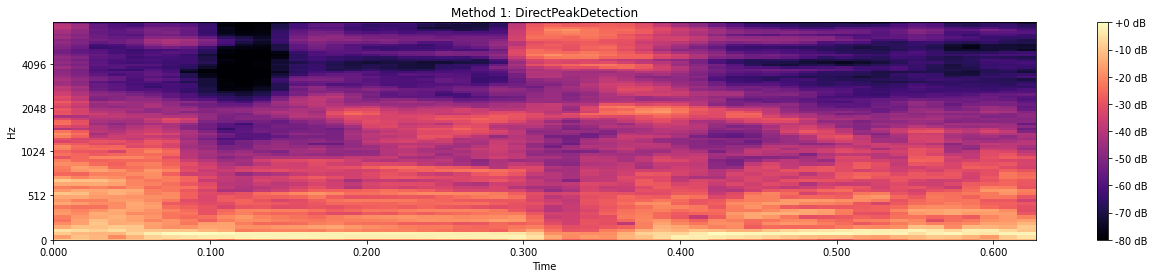

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(22,4))
img = librosa.display.specshow(
    librosa.power_to_db(
        librosa.feature.melspectrogram(y=f1, sr=sr, n_mels=80, fmax=8000), 
        ref=np.max
    ), 
    x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax
)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Method 1: DirectPeakDetection')
plt.show()

In [10]:
e2, f2 = algo2("/content/envelope-and-fine-structure/_sample/chonsh_hello.wav")

Models pca + Regression loaded successfully [f0, ratio: 89.80466200000001] 


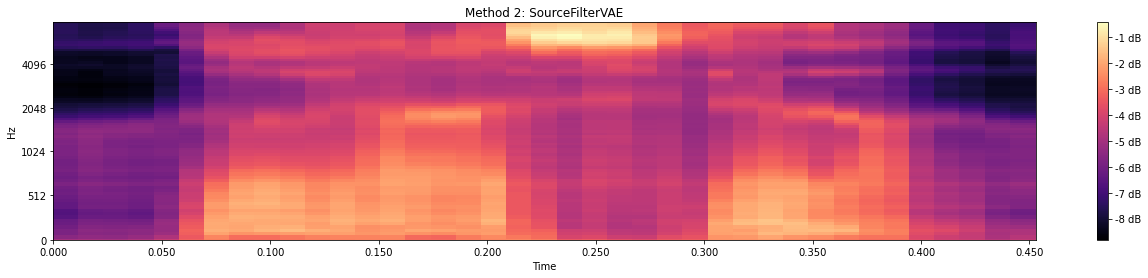

In [11]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22,4))
img = librosa.display.specshow(
    e2, 
    x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax
)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Method 2: SourceFilterVAE')
plt.show()

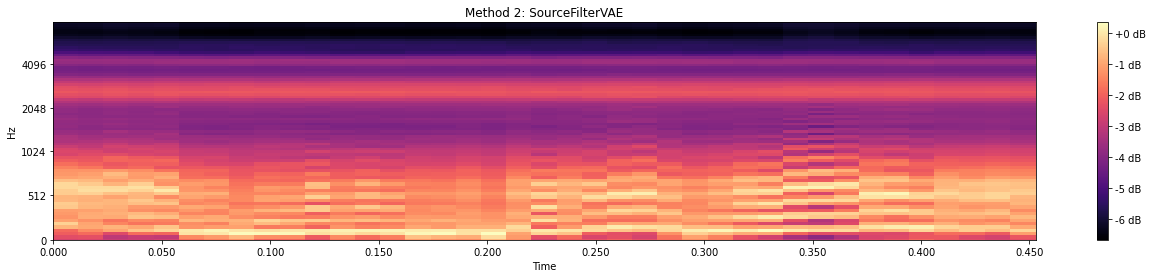

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22,4))
img = librosa.display.specshow(
    f2, 
    x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax
)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Method 2: SourceFilterVAE')
plt.show()